In [3]:
import pandas as pd

dataframes = []

# Loop through the range of years
for year in range(1998, 2024):
    df = pd.read_csv(f'../DATA/{year}.csv')
    df = df[df['EVENT_TYPE'] == 'Tornado']
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('../DATA/combined_data.csv', index=False)

combined_df.head()


C:\Users\zaidf\AppData\Local\Temp\ipykernel_8972\3294620417.py:7: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../DATA/{year}.csv')
C:\Users\zaidf\AppData\Local\Temp\ipykernel_8972\3294620417.py:7: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'../DATA/{year}.csv')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,199806,2,2050,199806,2,2100,2149256,5669115,MARYLAND,24.0,...,3.0,SW,FRIENDSVILLE,39.67,-79.50,39.63,-79.45,An F2 tornado passed southeast through souther...,NaN,PDC
1,199806,2,2038,199806,2,2042,2149257,5669116,MARYLAND,24.0,...,2.0,SE,FINZEL,39.73,-78.97,39.70,-78.93,An F2 tornado passed through the town of Finze...,NaN,PDC
2,199806,13,1545,199806,13,1545,2149637,5668053,OKLAHOMA,40.0,...,1.0,W,LONGDALE,36.13,-98.57,36.13,-98.57,"Summary of events of June 13, 1998:During the ...",The Blaine County Sheriff reported a brief tor...,PDC
3,199806,2,2045,199806,2,2050,2149255,5669114,WEST VIRGINIA,54.0,...,3.0,SE,GLADE FARMS,39.72,-79.55,39.67,-79.50,An F2 tornado passed southeast through souther...,NaN,PDC
4,199806,2,1720,199806,2,1728,2149234,5668877,PENNSYLVANIA,42.0,...,3.0,SE,MANOR,40.37,-79.75,40.30,-79.63,An F1 tornado touched down 5 miles northwest o...,NaN,PDC


C:\Users\zaidf\AppData\Local\Temp\ipykernel_37784\1260391302.py:5: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('combined_data.csv')


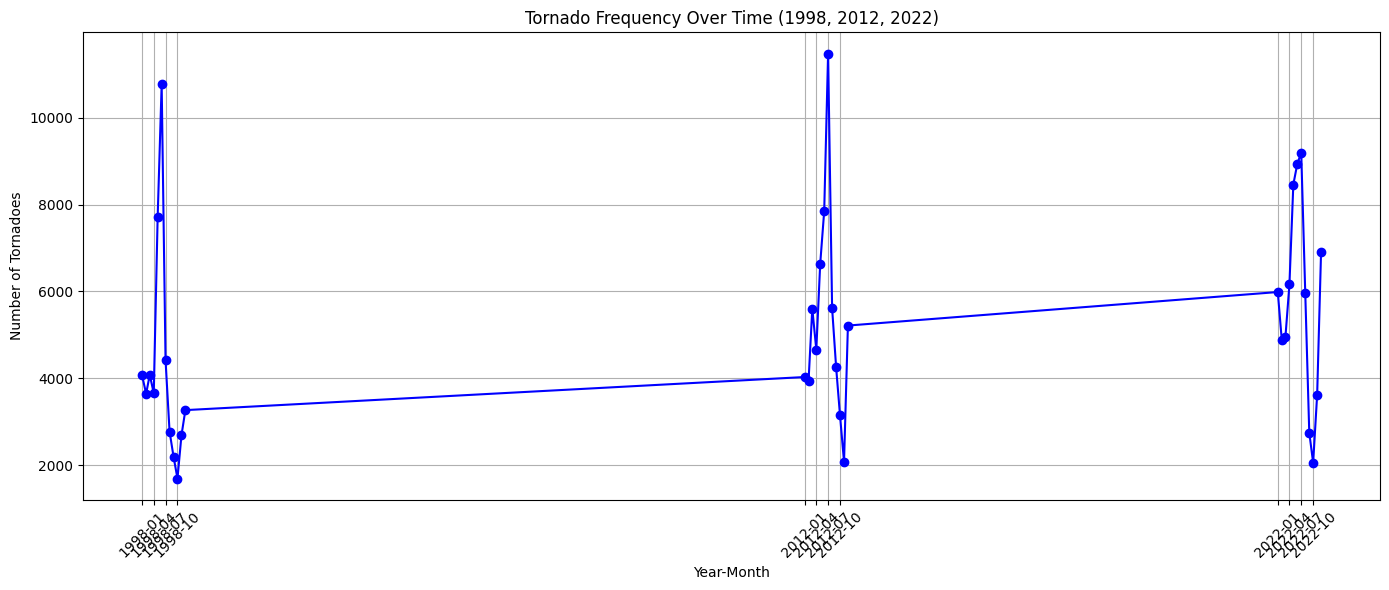

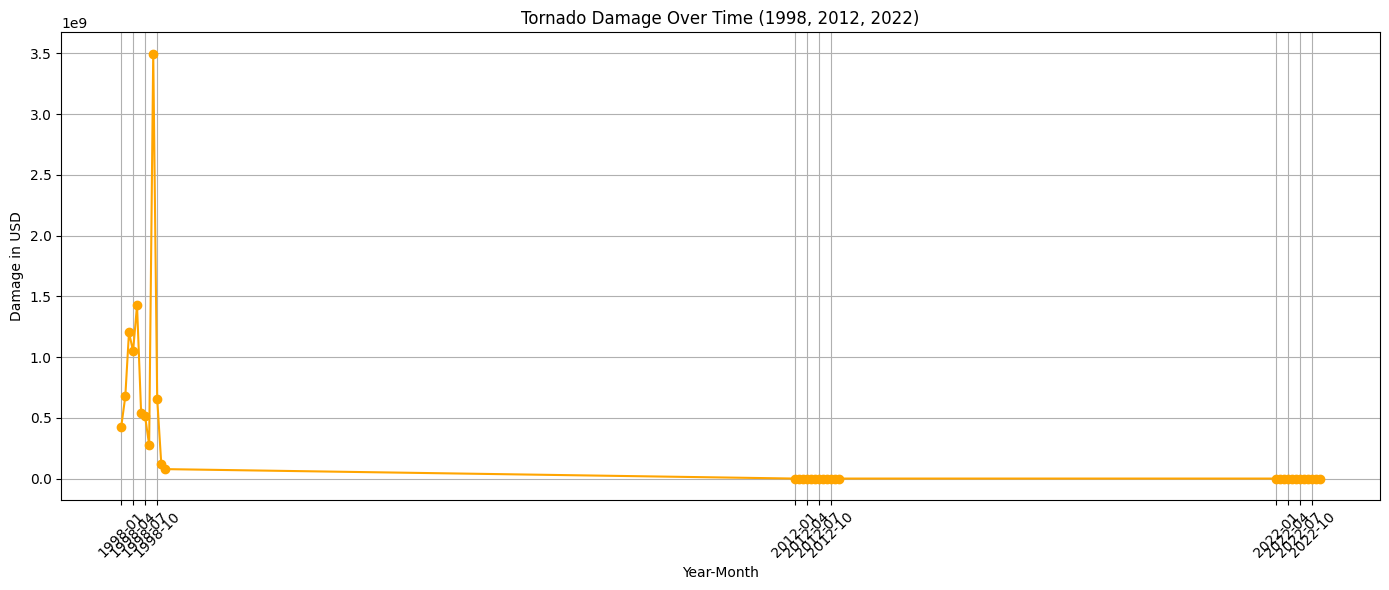

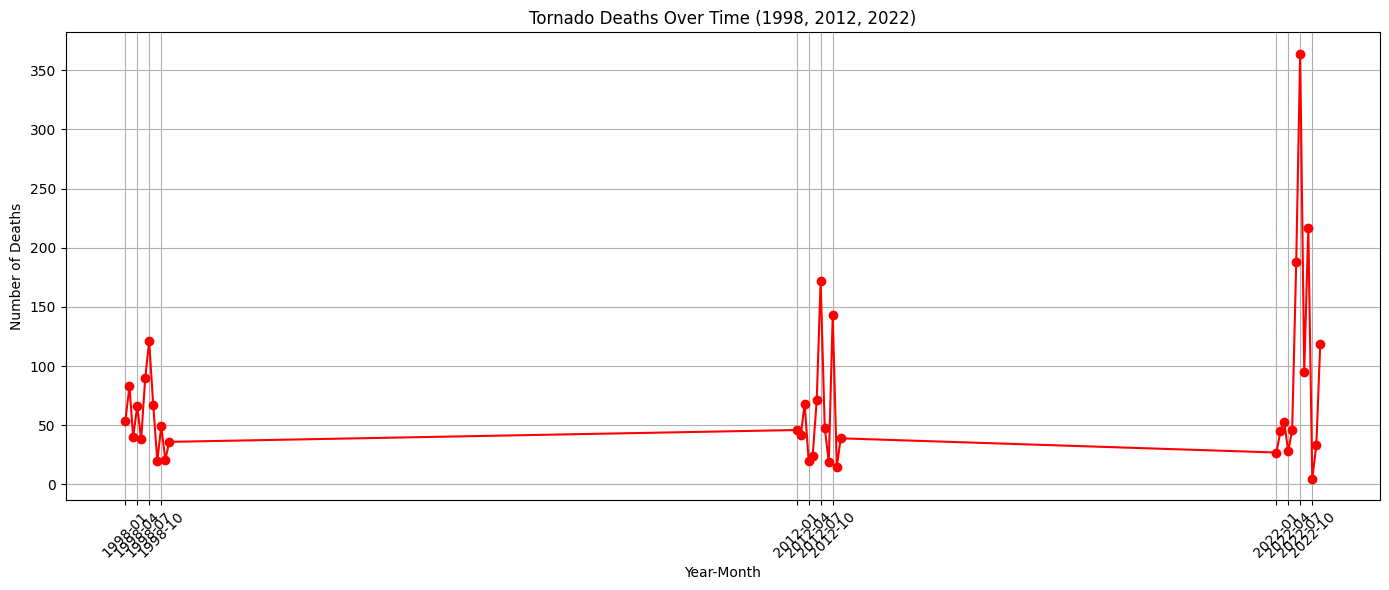

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined CSV data
combined_df = pd.read_csv('combined_data.csv')

# Convert the BEGIN_YEARMONTH column to a datetime format for easier plotting
combined_df['BEGIN_YEARMONTH'] = pd.to_datetime(combined_df['BEGIN_YEARMONTH'].astype(str), format='%Y%m')

# Filter data to only include the years 1998, 2012, and 2022
filtered_df = combined_df[combined_df['BEGIN_YEARMONTH'].dt.year.isin([1998, 2012, 2022])]

# Define a function to plot with specific years (1998, 2012, 2022) and their months
def plot_with_specific_years(x_values, y_values, title, xlabel, ylabel, color='blue'):
    plt.figure(figsize=(14, 6))  # Increase figure size to give more space
    plt.plot(x_values, y_values, marker='o', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set x-ticks for every third month
    ax = plt.gca()
    ax.set_xticks(x_values[::3])  # Show every third month to reduce clutter
    ax.set_xticklabels(x_values[::3].strftime('%Y-%m'), rotation=45)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 1: Tornado Frequency over Time (for 1998, 2012, and 2022)
tornado_frequency = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH']).size()
plot_with_specific_years(tornado_frequency.index, tornado_frequency.values,
                         title='Tornado Frequency Over Time (1998, 2012, 2022)',
                         xlabel='Year-Month', ylabel='Number of Tornadoes')

# Plot 2: Tornado Damage over Time (for 1998, 2012, and 2022)
filtered_df['DAMAGE_PROPERTY'] = pd.to_numeric(filtered_df['DAMAGE_PROPERTY'].str.replace('K', '000').str.replace('M', '000000'), errors='coerce')
tornado_damage = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH'])['DAMAGE_PROPERTY'].sum()
plot_with_specific_years(tornado_damage.index, tornado_damage.values,
                         title='Tornado Damage Over Time (1998, 2012, 2022)',
                         xlabel='Year-Month', ylabel='Damage in USD', color='orange')

# Plot 3: Tornado Deaths over Time (for 1998, 2012, and 2022)
filtered_df['TOTAL_DEATHS'] = filtered_df['DEATHS_DIRECT'] + filtered_df['DEATHS_INDIRECT']
tornado_deaths = filtered_df.groupby(filtered_df['BEGIN_YEARMONTH'])['TOTAL_DEATHS'].sum()
plot_with_specific_years(tornado_deaths.index, tornado_deaths.values,
                         title='Tornado Deaths Over Time (1998, 2012, 2022)',
                         xlabel='Year-Month', ylabel='Number of Deaths', color='red')

